In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

%matplotlib inline
#plt.style.use('ggplot')

# Comparar historico distintas estrategias

In [7]:
# Descarga datos historicos multifondos AFP Cuprum
url_data = 'https://rawgit.com/collabmarket/data_afp/master/data/VC-CUPRUM.csv'
afp_name = url_data.split('-')[-1].split('.')[0] # Nombre de la afp
karg_csv = dict(delimiter=';', decimal=',', index_col=0, parse_dates=True)
afp = pd.read_csv(url_data, **karg_csv) # Crea DataFrame con los datos
afp.dropna(inplace=True) # Elimina filas sin datos de para todos los fondos

## Estrategia base propuesta

Es la estrategia más simple de cambio de fondo A-E, cualquier estrategia más complicada debería entregar mejor rentabilidad, en caso contrario está haciendo overfitting o es inconsistente.
Fuente https://github.com/collabmarket/algorithms_afp

In [111]:
# Delta es Valor relativo (diferencia o resta) entre valores cuota de A y E
afp['delta'] = afp.A - afp.E
# Parametros: ['median',365] (elejimos mediana movil 365 dias)
afp['zero'] = afp.delta.rolling(window=365,center=False).median()
# Criterios de Entrada a renta variable
# Parametros: ['quantile',0.1,365] (elejimos cuantil 10% ventana 365 dias)
afp['entra'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.1)
# Criterios de Salida a renta fija
# Parametros: ['quantile',0.9,365] (elejimos cuantil 90% ventana 365 dias)
afp['sale'] = afp.delta.rolling(window=365,center=False).quantile(quantile=0.9)
# Criterio rentabilidad de corto plazo (15 dias)
afp['rate'] = afp.delta.pct_change(15)
# Solo a partir de 2011-07-01
#afp = afp['2011-07-01':]
# Caso base se marca como desconocido, Sin Informacion (S/I)
afp['estrategia'] = 'S/I'
# Segnales de largo plazo 
afp.loc[afp.delta < afp.zero,'estrategia'] = 'E'
afp.loc[afp.delta > afp.zero,'estrategia'] = 'A'
# Segnales de mediano plazo
afp.loc[(afp.delta > afp.entra) & (afp.delta < afp.zero) & (afp.rate > 1),'estrategia'] = 'E->A'
afp.loc[(afp.delta > afp.sale) & (afp.rate < -1),'estrategia'] = 'A->E'

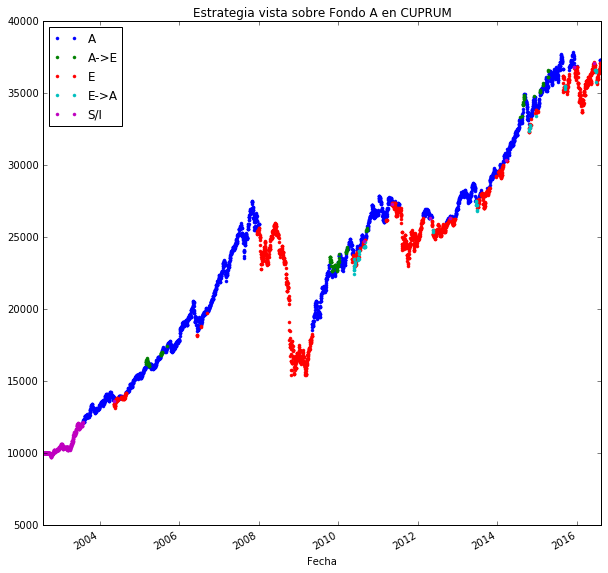

In [112]:
# Grafico estrategia base
gb = afp[['A','B','C','E','estrategia']].groupby('estrategia')
fig, ax = plt.subplots()
gb.A.plot(style='.', title='Estrategia vista sobre Fondo A en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)

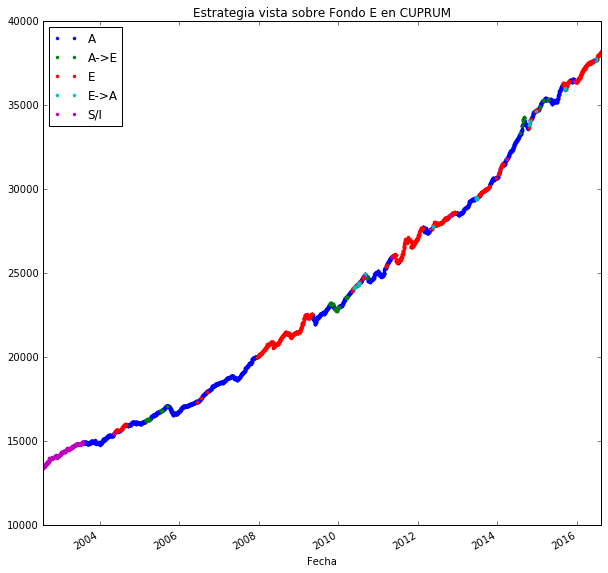

In [113]:
fig, ax = plt.subplots()
gb.E.plot(style='.', title='Estrategia vista sobre Fondo E en %s'%(afp_name), figsize=(10, 10), ax=ax)
plt.legend(loc=2)

In [114]:
# Indicadores de Riesgo sistemico
# Dow Jones Industrial Average index, indicador del sistema financiero global
dow = pd.read_csv('data_quandl/dow.csv', **karg_csv)
# West Texas Intermediate, precio del petróleo indicador base costo materias primas, precursor inflación global
wti = pd.read_csv('data_quandl/wti.csv', **karg_csv)
# Effective Federal Funds Rate, indicador base del costo de financiamiento global
fedrate = pd.read_csv('data_quandl/fedrate.csv', **karg_csv)
# Monetary Base; Total, Dinero circulante para inversiones e intercambio comercial.
money = pd.read_csv('data_quandl/money.csv', **karg_csv)
# Total Public Debt as Percent of Gross Domestic Product, nivel de Deuda del emisor de dolares 
debt = pd.read_csv('data_quandl/debt.csv', **karg_csv)
# Indicador local tipo de cambio Pesos Chilenos a Dolar Estados Unidos.
usdclp = pd.read_csv('data_quandl/usdclp.csv', **karg_csv)

df = pd.DataFrame()
df['dow'] = dow.Value
df['wti'] = wti.Value
df['fedrate'] = fedrate.FEDFUNDS.resample('D').bfill()
df['usdclp'] = usdclp.Rate
df['money'] = money.BOGMBASEW.resample('D').bfill()
df['debt'] = debt.GFDEGDQ188S.resample('D').bfill()
# Datos ultimos 13 años
year = datetime.now().year
init = str(year - 13)
df = df.loc[init:]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000A496ADD8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000A567F128>], dtype=object)

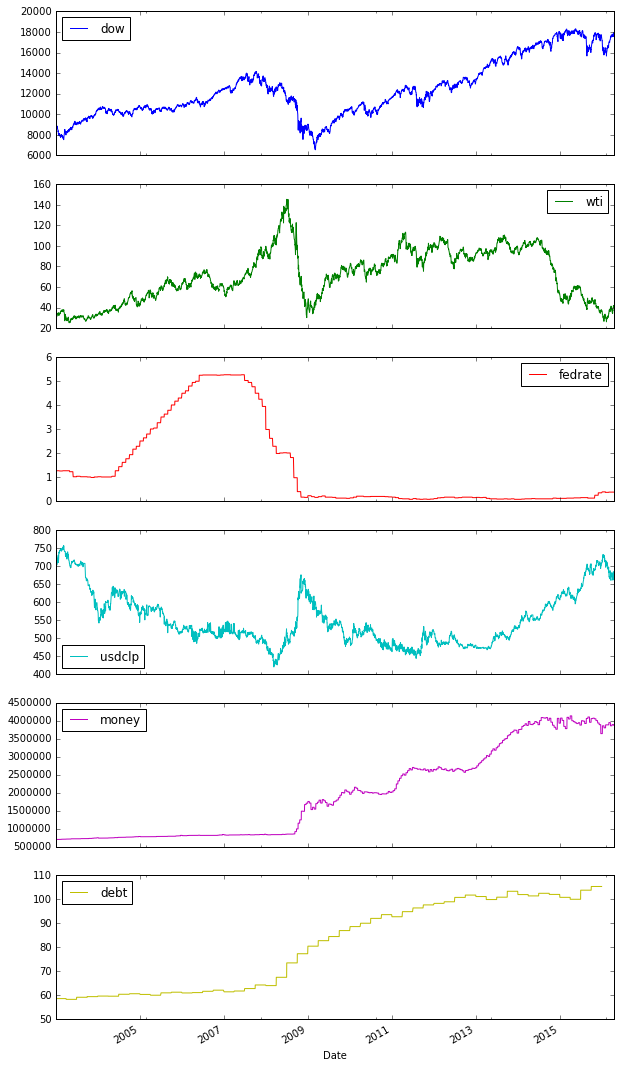

In [115]:
df.plot(subplots=True, figsize=(10, 20), sharex=True)

In [116]:
afp_df = pd.concat([afp, df], axis=1)

In [117]:
afp_df.columns

Index([u'A', u'B', u'C', u'D', u'E', u'delta', u'zero', u'entra', u'sale',
       u'rate', u'estrategia', u'dow', u'wti', u'fedrate', u'usdclp', u'money',
       u'debt'],
      dtype='object')

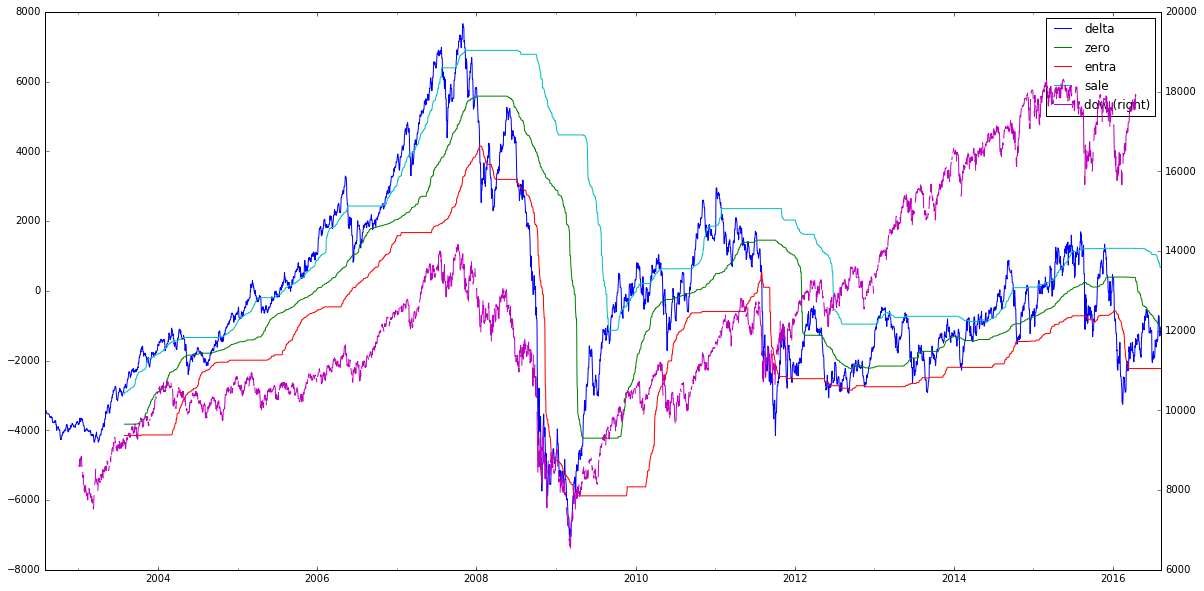

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
afp_df.plot(y=['delta','zero','entra','sale'], ax=ax)
afp_df.plot(y=['dow'], ax=ax, secondary_y=True)

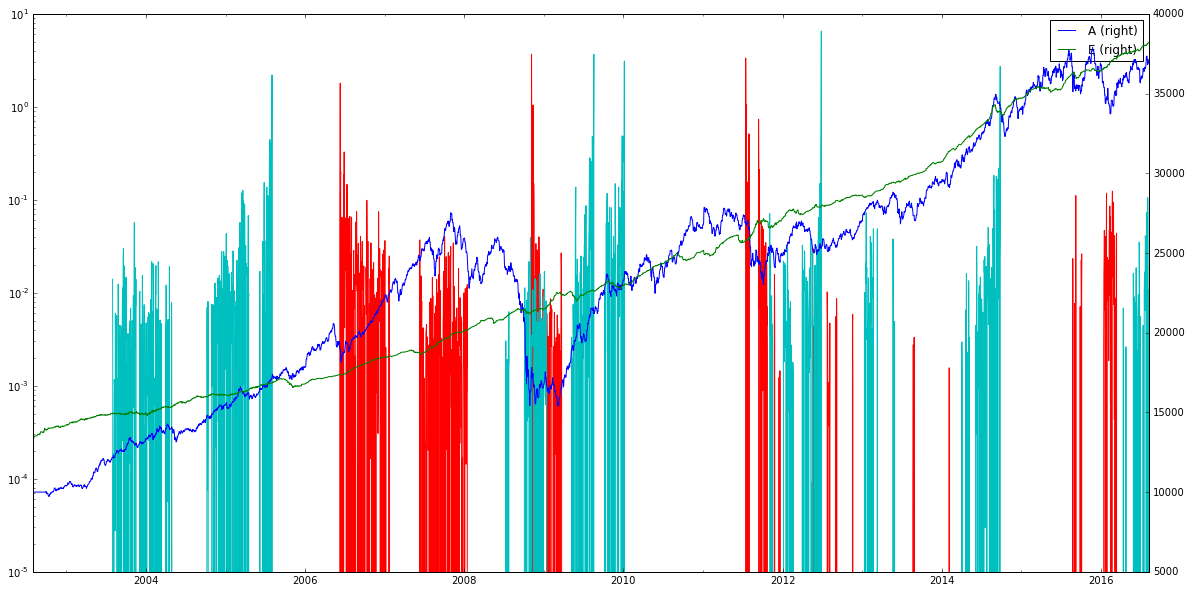

In [109]:
fig, ax = plt.subplots(figsize=(20,10))
afp_df.plot(y=['A','E'], ax=ax, secondary_y=True)
afp_df['entra'].pct_change().plot(ax=ax, logy=True)
#~afp_df['entra'].pct_change().multiply(-1).plot(ax=ax, logy=True)
#~afp_df['zero'].pct_change().plot(ax=ax, logy=True)
#~afp_df['zero'].pct_change().multiply(-1).plot(logy=True)
#~afp_df['sale'].pct_change().plot(ax=ax, logy=True)
afp_df['sale'].pct_change().multiply(-1).plot(ax=ax, logy=True)
#~afp_df['delta'].pct_change().plot(ax=ax, logy=True)
#~afp_df['delta'].pct_change().multiply(-1).plot(ax=ax, logy=True)

In [4]:
#%qtconsole